In [1]:
import scipy
from scipy.cluster.hierarchy import linkage
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from random import choices, sample
from collections import Counter

In [2]:
def h_cluster(X, max_clusters=None):
    """
    Builds a hierarchical clustering using the linkage function from scipy 
    (agglomerative clustering using ward's linkage and euclidean distance).
    Records clusters as they merge; output clusters start at the root node.
    The two child nodes, associated with each new node, are recorded for reference.

    Args:
        X (np.ndarray): [N x d] matrix, containing N observations of d-dimensional input data
        max_clusters (int, optional): Determines the maximum number of clusters defined. 
            Default value (N-1) considers clusters down to single observations.

    Returns:
        list: A list containing N-1 arrays, each represents a node in the hierarchical tree,
            containing the data indices associated with each cluster.
        np.ndarray: A [2 x N-1] matrix, containing the 2 child nodes for each cluster.
    """
    
    if max_clusters is None:
        max_clusters = len(X) - 1

    # Build hierarchical tree
    Z = linkage(X, method='ward', metric='euclidean')

    N = len(X)
    u = [None] * (N - 1)
    ch = np.zeros((2, N - 1), dtype=int)

    # Using the output of linkage (Z) to build clusters
    for m in range(len(u)):
        # Join parts p1 & p2 of the clustering together using Z info
        if Z[m, 0] < N:
            p1 = [Z[m, 0]]
            c1 = int(p1[0])
        else:
            p1 = u[int(Z[m, 0] - N)]
            c1 = 2*N - int(Z[m, 0]) - 1

        if Z[m, 1] < N:
            p2 = [Z[m, 1]]
            c2 = int(p2[0])
        else:
            p2 = u[int(Z[m, 1] - N)]
            c2 = 2*N - int(Z[m, 1]) - 1
     
        u[m] = p1 + p2
        ch[:, m] = [c1, c2]

    u = list(reversed(u))
    u = u[:max_clusters]
    u_= [[int(x) for x in sublist] for sublist in u]
    u = [x for x in u_ if x]

    ch = np.fliplr(ch[:, :max_clusters])
    ch = ch.astype(int)
    
    return u, ch

In [3]:
def prune_label(P, u, Au, Lu, ch, z, N, eu, wu):
    """
    Function to refine the pruning (P) and labelling (L) for the DH active learner.
    
    Parameters:
    - P : list
        Input pruning, to be refined (array of node/cluster numbers).
    - u : dict
        Contains N-1 arrays. Each array represents a node in the hierarchical tree.
    - Au : list
        Logistic array, indicating the admissibility of each cluster in the current pruning.
    - Lu : dict
        Cell containing the majority label(s), for each node.
    - ch : numpy array
        2x(N-1) matrix containing the 2 children nodes for each cluster.
    - z : numpy array
        Sampled data information array.
    - N : int
        Total number of clusters.
    - eu : list
        Error associated with propagating the majority label to unlabelled instances.
    - wu : list
        Node weights - proportion of the total data in each node.
        
    Returns:
    - P_ : list
        Output (refined) pruning.
    - L : list
        The majority label for each cluster in the refined pruning.
    - XL : numpy array
        The labelled dataset provided by the DH learner.
    """
    
    L = [0] * len(u)  # Initialize admissible cluster label pairs
    P_ = list(P)  # Define working pruning
    print("length of u is ")
    print(len(u))


    for i, v in enumerate(P):  # For each node in the current pruning
        # LABEL parent node in case descendants are not admissible
        Lu[1] = 0  # Arbitrary label of root
        if len(P) != 1 and len(Lu[v]) == 1:
            L[v - 1] = Lu[v]

        # Identify first descendants...
        chv = ch[:, v - 1]
        Pv = [v]
        Achv = [Au[x - 1] for x in chv]

        # While at least one pair of siblings is admissible, refine and label Pv
        while np.sum(np.sum(Achv) == 2) >= 1:
            i_ch = [idx for idx, val in enumerate(Achv) if np.sum(val) == 2]

            for ich in i_ch:
                ep = eu[Pv[ich] - 1]
                ech = (1 / np.sum([wu[x - 1] for x in chv[:, ich]])) * np.sum(
                    [wu[x - 1] * eu[x - 1] for x in chv[:, ich]])
                Lch = [Lu[x] for x in chv[:, ich]]
                Lch_log = [len(x) == 1 for x in Lch]

                if len(Lu[Pv[ich]]) == 1 and ech < ep and np.sum(Lch_log) == 2:
                    Pv[ich] = 0
                    u_ = chv[:, ich]
                    Pv.extend(list(u_))

            Pv = [x for x in Pv if x != 0]

            if len(set(Pv)) > chv.shape[1]:
                chv = ch[:, [x - 1 for x in Pv]]
                Achv = [Au[x - 1] for x in chv.flatten()]
            else:
                break

        if len(Pv) > 1:
            print(f"\nTOTAL CLUSTERS {len(P_)}: nodes {Pv} replace node [{v}]")
            P_ = [x for x in P_ if x != v]
            P_.extend(Pv)
            for uw in Pv:
                L[uw - 1] = Lu[uw]

    xl = [0] * N
    for idx, v in enumerate(P):
        if len(P) >= len(set(z[:, -1])):
            xi = u[v]
            xl[xi - 1] = L[v - 1]

    for idx in range(z.shape[0]):
        z_ = int(z[idx, 0])
        zl = z[idx, -1]
        xl[z_ - 1] = zl

    XL = np.array([[idx, x] for idx, x in enumerate(xl) if x != 0])

    return P_, L, XL

In [4]:
def DH_AL(u, ch, B, T, y):
    # Initialize variables
    N = len(u[0])
    print("N is ", N)
    Nu = [len(ue) for ue in u]
    wu = np.array(Nu) / N
    
    z = np.empty((0, 3))
    uz = [ [] for _ in range(N-1)]
    u_ = u.copy()
    
    pl = [None] * len(u)
    Aul = [None] * len(u)
    Au = np.zeros(len(u) + N)
    eu = np.ones(len(u) + N)
    Lu = [None] * len(u)
    
    P = [0]
    
    for t in range(1, T+1):
        for b in range(1, B+1):
            # Select v from P
            prop = wu[P]
            for i, v in enumerate(P):
                coeff = 1 if len(P) == 1 else 0 if not u_[v] else 1 - max(pl[v][:, -2])
                prop[i] *= coeff
            
            prob = prop / np.sum(prop)
            vi = choices(range(len(prob)), prob)[0]
            
            # Query label
            s = 0
            if len(u_[P[vi]]) != 0:
                s = int(sample(u_[P[vi]], 1)[0])
            else:
                continue
            for ui in u_:
                if s in ui:
                    ui.remove(s)
            
            l = y[s]
            
            sampled_vec = np.array([s, P[vi], l])
            z = np.vstack([z, sampled_vec])
            
            # Update node counts
            u_i = [i for i, ue in enumerate(u) if s in ue]
            for uw in u_i:
                uz[uw].append((s, l))
                nu = len(uz[uw])
                
                cl, c = zip(*Counter([l for s, l in uz[uw]]).items())
                p_l = np.array(c) / nu
                
                delta = 1 / nu + np.sqrt((p_l * (1 - p_l)) / nu)
                lb = np.maximum(p_l - delta, 0)
                ub = np.minimum(p_l + delta, 1)
                
                pl[uw] = np.column_stack((cl, p_l, lb, ub))
                Lu[uw] = cl[np.argmax(p_l)]
                
        # Update admissibilities, error/scores
        u_i = [i for i, ple in enumerate(pl) if ple is not None]
        for uw in u_i:
            beta = 1.5
            p_l = pl[uw]
            if len(uz[uw]) > 1:
                LHS = p_l[:, -2]
                RHS = beta * p_l[:, -1] - 1
                a_l = LHS[:, None] > RHS
                
                a_l[np.diag_indices_from(a_l)] = False
                idx = np.all(a_l, axis=1)
                
                Aul[uw] = p_l[idx, 0]
                Au[uw] = np.any(idx)
                eu[uw] = 1 - np.max(p_l[:, 1]) if np.any(idx) else 1
                
        eu[Au == 0] = 1
        
        # Refine pruning & labelling
        P, L, XL = prune_label(P, u, Au, Lu, ch, z, N, eu, wu)
    
    return XL, np.array(z), P, L

In [5]:
"""
example run from https://github.com/labull/EngineeringPatternRecognition/tree/main/matlab/cluster_based_active_learning
n = 100;
B = 3; % batch size
t = n/3; % number of runs

% run the DH learner
[xl, z] = DH_AL(u, ch, B, t, Y);
"""

'\nexample run from https://github.com/labull/EngineeringPatternRecognition/tree/main/matlab/cluster_based_active_learning\nn = 100;\nB = 3; % batch size\nt = n/3; % number of runs\n\n% run the DH learner\n[xl, z] = DH_AL(u, ch, B, t, Y);\n'

In [6]:
from reader import fetch_signals
from preprocess import preprocess
from feature_extractor import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# gets X_train, y_train or X_test, y_test (pca and std should be None if train=True)
def get_train_test(pca = None, scaler = None, train = True):  
    print("benchmark 0")  
    signals, labels = fetch_signals('C:\\Users\\amroa\\Documents\\thesis\\data', train = train)
    print("benchmark 1")
    preprocessed_sig = np.array([preprocess(signal) for signal in signals])
    print("benchmark 2")
    print(preprocessed_sig.shape)

    # extract the characteristics
    X_train_time =  np.apply_along_axis(time_domain_characteristics, axis = 1, arr = preprocessed_sig) 
    print("benchmark 3")
    X_train_freq = np.apply_along_axis(frequency_domain_characteristics, axis = 1, arr = preprocessed_sig) 
    print("benchmark 4")
    Y = np.array(labels) - 1

    # unstd stands for unstandardized
    X_unstd = np.hstack((X_train_time, X_train_freq))
    mask_finite = np.isfinite(X_unstd).all(axis=1)
    X_unstd = X_unstd[mask_finite]
    Y = Y[mask_finite]

    # standardize the data and reduce dimensionality using PCA
    if ((scaler  == None) or (pca == None)):
        scaler = StandardScaler()
        X_std = scaler.fit_transform(X_unstd)
        pca = PCA(n_components=0.9, svd_solver = 'full') 
        X = pca.fit_transform(X_std)

        # precompute
        np.save('x_train_std_no_pca.npy', X_std)
        np.save('x_train_std_pca.npy', X)
        np.save('y_train.npy', Y)

        return X, Y, pca, scaler
    else:
        X_std = scaler.transform(X_unstd)
        X = pca.transform(X_std)

        # precompute
        np.save('x_test_std_no_pca.npy', X_std)
        np.save('x_test_std_pca.npy', X)
        np.save('y_test.npy', Y)

        return X, Y, pca, scaler

    return None, None, None, None



In [7]:
X, Y, pca, scaler = get_train_test()
x_test, y_test, _ , _ = get_train_test(pca = pca, scaler = scaler, train = False)  

benchmark 0
benchmark 1
benchmark 2
(2244, 16384)
benchmark 3
benchmark 4


UnboundLocalError: cannot access local variable 'X_std' where it is not associated with a value

In [ ]:
print(x_test.shape)
print(y_test.shape)

(60718, 715)
(60718,)


In [ ]:
# Random sampling strategy (makes sure all *different* labels are included, plus whatever is needed to fill the algorithm run budget of t*B)
def sample_indices_covering_all_Y_values(Y, N):
    unique_values = np.unique(Y)
    sampled_indices = []
    
    if N < len(unique_values):
        raise ValueError(f"N must be greater than or equal to the number of unique values in Y ({len(unique_values)}).")
        
    for value in unique_values:
        possible_indices = np.where(Y == value)[0]
        sampled_index = np.random.choice(possible_indices)
        sampled_indices.append(sampled_index)
        
    # calculate the remaining number of indices needed
    remaining = N - len(unique_values)
    
    # exclude already sampled indices
    all_indices = np.arange(len(Y))
    remaining_indices = np.setdiff1d(all_indices, sampled_indices)
    
    # sample additional random indices to meet the required N
    additional_indices = np.random.choice(remaining_indices, size=remaining, replace=False)
    
    # combine original sampled indices with the additional random indices
    final_sampled_indices = np.concatenate([sampled_indices, additional_indices])
    
    return final_sampled_indices


QUERY BUDGET ------ 20
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)

QUERY BUDGET ------ 40
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(17472, 515)
(17472,)

QUERY BUDGET ------ 60
(17472, 515)
(17472,)
(17472, 515)
(17472,)
(174

c:\Users\amroa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
********** done ****************

QUERY BUDGET ------ 40
N is  2241
length of u is 
100
length of u is 
100
********** done ****************
N is  2241
length of u is 
100
length of u is 
100
*********

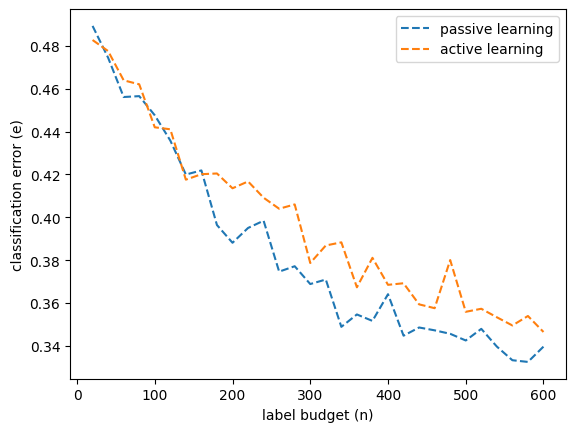

In [ ]:
from predict import predict
from predict import binarize

T = 30  # maximum number of runs (max label budget T*B = 600)
B = 20  # batch size
reps = 20  # number of repeats for each experiment

# For storing error
e_rs = []

for t in range(1, T + 1):
    print(f'\nQUERY BUDGET ------ {t * B}')
    acc = []  # accuracy for each repeat
    for r in range(reps):
        # define the training-set by a random sample from available data
        train_idx = np.random.choice(X.shape[0], t * B, replace=False)
        x_train = X[train_idx, :]
        y_train = Y[train_idx]
        
        # CLASSIFICATION
        y_pred = predict(x_train, y_train, x_test, 1)
        acc.append(np.sum(y_pred == binarize(y_test)) / len(y_test))

    e_rs.append(1 - np.mean(acc))


# CLUSTER BASED ACTIVE LEARNING: the DH learner for an increasing label budget
e_al = []
for t in range(1, T + 1):
    print(f'\nQUERY BUDGET ------ {t * B}')
    acc = []
    for r in range(reps):
        # INITIAL CLUSTERING
        u, ch = h_cluster(X, max_clusters=100)

        # HIERARCHICAL SAMPLING FOR ACTIVE LEARNING
        xl, z, p, l = DH_AL(u, ch, B, t, Y)
        print("********** done ****************")
        train_idx = xl[:, 0].astype(int)  # convert to int for indexing
        x_train = X[train_idx, :]
        y_train = xl[:, 1]

        # CLASSIFICATION
        y_pred = predict(x_train, y_train, x_test, 1)
        acc.append(np.sum(y_pred == binarize(y_test)) / len(y_test))

    e_al.append(1 - np.mean(acc))

# PLOT
plt.figure(3)
plt.plot(np.arange(B, B * T + 1, B), e_rs, '--')
plt.plot(np.arange(B, B * T + 1, B), e_al, '--')
plt.xlabel('label budget (n)')
plt.ylabel('classification error (e)')
plt.legend(['passive learning', 'active learning'])
plt.show()


In [ ]:

with open('e_rs.txt', 'w') as f:
    for item in e_rs:
        f.write(f"{item}\n")

In [ ]:
with open('e_al.txt', 'w') as f:
    for item in e_al:
        f.write(f"{item}\n")